# Integrating Machine Learning into Differential Equations for Automated Discovery of Missing Physics and Optimal Control

**Frank Schäfer** \
**Julia Lab** \
**Computer Science and Artifical Intelligence Laboratory** \
**MIT**



## Collaborators

### SciML team
- https://github.com/orgs/SciML/people 
- Chris Rackauckas
- Yingbo Ma
- Julius Martensen

###  [Julia Lab](https://julia.mit.edu/) and other collaborators
- Julian Arnold, Gaurav Arya, Christoph Bruder, Vaibhav Dixit, Alan Edelman, Flemming Holtorf, Niels Lörch, Avik Pal, Moritz Schauer ...


## What to expect in this presentation

### Explore techniques in *scientific machine learning*, including
- Universal differential equations (UDEs)
- Automatic differentiation (AD)
- Sparse identification of nonlinear dynamics (SINDy)

### Large set of involved *packages*:
- SciML tools (DifferentialEquations.jl, SciMLSensitivity.jl, DataDrivenDiffEq.jl, …)
- Machine learning tools (Flux.jl, Lux.jl, …)
- Differentiation tools (FiniteDiff.jl, ForwardDiff.jl, Enzyme,jl, Zygote.jl, ReverseDiff.jl, SparseDiffTools.jl, AbstractDifferentiation.jl, …)
- Optimization tools (JuMP, Optim.jl, Optimisers.jl, NLopt.jl, …)

In [ ]:
using Pkg
pkg"activate @DigiWell"
# pkg"add DifferentialEquations, DataDrivenDiffEq, DataDrivenSparse, SciMLSensitivity" 
# pkg"add Optimization, OptimizationOptimisers, OptimizationOptimJL, LinearAlgebra, Statistics"
# pkg"add ComponentArrays, Lux, Zygote, FiniteDiff, ForwardDiff, Plots, StableRNGs, QuadGK, LaTeXStrings, StochasticAD, Distributions"  

In [1]:
# SciML Tools
using DifferentialEquations, DataDrivenDiffEq, SciMLSensitivity, DataDrivenSparse
using Optimization, OptimizationOptimisers, OptimizationOptimJL 

# Standard Libraries
using LinearAlgebra, Statistics

# External Libraries
using ComponentArrays, Lux, Zygote, FiniteDiff, ForwardDiff, Plots, LaTeXStrings, StableRNGs, QuadGK, StochasticAD, Distributions

# Set a random seed for reproducible behaviour
rng = StableRNG(4578478478) 

StableRNGs.LehmerRNG(state=0x00000000000000000000000221cc131d)

## Resources:
- Tutorial on [Automated Discovery of Missing Physics by Embedding Machine Learning into Differential Equations](https://docs.sciml.ai/Overview/stable/showcase/missing_physics/#autocomplete)
- [SciMLSensitivity documentation](https://docs.sciml.ai/SciMLSensitivity/stable/)
- Chris' JuliaCon 2020 workshop on [Doing Scientific Machine Learning (SciML) With Julia](https://www.youtube.com/watch?v=QwVO0Xh2Hbg)

## Predator-prey model

$$
\begin{align*}
\frac{d\text{🐇}}{dt} &= \alpha \text{🐇} - \beta \text{🐇} \text{🐺} \\
\frac{d\text{🐺}}{dt} &= -\delta \text{🐺} + \gamma \text{🐇} \text{🐺}
\end{align*}
$$

where
- 🐇 represents the population of prey.
- 🐺 represents the population of predators.
- α, β, γ, and δ are parameters governing the interactions between the prey and predator populations.

... with possible modifications, such as

- stochasticity 
- events
- delays

## Goals

Demonstrate

- Parameter inference
- Model selection & discovery
- Stochastic optimal control

for variations of the predator-prey model.

## Problem setup

In [2]:
function lotka(u, p, t)
    # right-hand-side of Lotka-Volterra system
    # inputs:
    #       - u : current state u[1] = population of prey,
    #                           u[2] = population of predator
    #       - p : parameters
    # returns:
    #       - du/dt : rate of change of population sizes

    🐇, 🐺 = u
    α, β, γ, δ = p
    d🐇 = α * 🐇 - β * 🐇 * 🐺
    d🐺 = - δ * 🐺 + γ * 🐇 * 🐺
    return [d🐇, d🐺]
end

lotka (generic function with 1 method)

In [3]:
# Define the experimental parameters

tspan = (0.0, 5.0) # time span
u0 = [3.0, 1.5] # initial condition
p_ = [1.3, 0.9, 0.8, 1.8] # parameters

# Define ODE problem
prob = ODEProblem(lotka, u0, tspan, p_)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: false
timespan: (0.0, 5.0)
u0: 2-element Vector{Float64}:
 3.0
 1.5

In [ ]:
u0

## Solving the forward problem

In [4]:
solve(prob, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 13-element Vector{Float64}:
 0.0
 0.11096172453189868
 0.31572095348055956
 0.5708642236188479
 0.9324752097601212
 1.260002055773548
 1.6847011913649121
 2.195246222645443
 2.716339691552002
 3.3198310502415405
 3.9414120678200564
 4.7370639636877705
 5.0
u: 13-element Vector{Vector{Float64}}:
 [3.0, 1.5]
 [2.9683948576135544, 1.6013718066369667]
 [2.834898830401392, 1.7840051266358061]
 [2.5659391197847987, 1.9585369366867613]
 [2.1362834113289946, 2.0149828432982555]
 [1.8366581424168973, 1.875309977159519]
 [1.6489930705879905, 1.5684283481912151]
 [1.6918482847377148, 1.2268197812266382]
 [1.977932242112537, 1.0240993492122925]
 [2.519572761097714, 1.0177983751762643]
 [2.9818511798639826, 1.3276289384063977]
 [2.5459920555053204, 1.9664986333017946]
 [2.229058121334685, 2.023880670298055]

In [8]:
solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat=0.25)

retcode: Success
Interpolation: 1st order linear
t: 21-element Vector{Float64}:
 0.0
 0.25
 0.5
 0.75
 1.0
 1.25
 1.5
 1.75
 2.0
 2.25
 2.5
 2.75
 3.0
 3.25
 3.5
 3.75
 4.0
 4.25
 4.5
 4.75
 5.0
u: 21-element Vector{Vector{Float64}}:
 [3.0, 1.5]
 [2.887627784433959, 1.727516712157343]
 [2.6482639916400594, 1.9192485034436653]
 [2.3487008248219574, 2.017701979242946]
 [2.064453590549855, 1.9987179614033797]
 [1.8438678825730723, 1.881485266549588]
 [1.703009712202518, 1.7081460131893103]
 [1.6393640730331054, 1.5195639964810663]
 [1.6447265171289325, 1.3441375367296844]
 [1.7112984069973336, 1.1976850446295708]
 [1.8328665768330736, 1.0875608539891202]
 [2.003477084998431, 1.0169539822918447]
 [2.2147111866310425, 0.9881213726689747]
 [2.4518609197060184, 1.0044581117317344]
 [2.6894368793838694, 1.0712816272976193]
 [2.8879222669546576, 1.1944014206222588]
 [2.996791914496485, 1.3744348800198753]
 [2.970940334536876, 1.5956831393088031]
 [2.799677618770784, 1.8159239813521109]
 [2.5253

### Handling stochasticity, explicit and implicit events, time delays, ...

In [6]:
# Stochasticity
lotka_noise(u, p, t) = [p[5] * u[1], p[6] * u[2]]
prob_SDE = SDEProblem(lotka, lotka_noise, u0, tspan, [p_..., 0.1, 0.0])
solution_SDE = [Array(solve(prob_SDE, SOSRI())(0.0:1.0:10.0)) for i in 1:20] # 20 solution samples

20-element Vector{Matrix{Float64}}:
 [3.0 1.6049813266133872 … 12.683411430915545 15.408992416981311; 1.5 1.6944734752399668 … -1.2805354632753319 -2.228493740921556]
 [3.0 1.9631721768580466 … -27.252515546797117 -34.48327390187085; 1.5 2.0217608762962573 … -1.6917601072385862 -2.624620632426852]
 [3.0 2.047759882944215 … -17.607094849187828 -22.449116047274263; 1.5 1.9584533648346525 … -1.077530913279748 -1.834658898682681]
 [3.0 1.9979162622864723 … -15.913038412451538 -20.611552196811576; 1.5 2.2760016107683465 … 6.64512359661635 7.755639479429765]
 [3.0 2.013477957096722 … -16.42883168749835 -21.18843230966846; 1.5 1.870916959713535 … 3.614719064551748 4.09830428305423]
 [3.0 1.856486634547231 … 40.63746516185134 50.32880838764139; 1.5 1.9158461834261094 … -0.44621117452943 -1.0777750046743766]
 [3.0 1.9246772505096945 … 9.24133137645558 10.88622148425997; 1.5 1.9655303985523502 … 3.8674555530917476 4.413777325267458]
 [3.0 1.9967947155192316 … 14.469793426229888 17.56481815148324

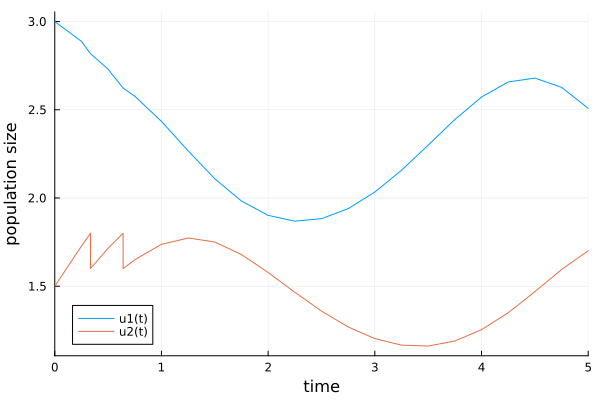

In [7]:
# Events
🔥🐺_condition(u, t, integrator) = u[2] - 1.8
🔥🐺_affect!(integrator) = integrator.u[2] -= 0.2
🔥🐺_cb = ContinuousCallback(🔥🐺_condition, 🔥🐺_affect!)
plot(solve(prob, Vern7(), callback=🔥🐺_cb, abstol=1e-12, reltol=1e-12, saveat=0.25), xlabel="time", ylabel="population size")

- [Stochastic differential equations](https://docs.sciml.ai/DiffEqDocs/stable/tutorials/sde_example/)
- [Hybrid differential equations](https://docs.sciml.ai/DiffEqDocs/stable/features/callback_functions/)
- [Delay differential equations](https://docs.sciml.ai/DiffEqDocs/stable/tutorials/dde_example/)
- [Parallel ensemble simulations](https://docs.sciml.ai/DiffEqDocs/dev/features/ensemble/)

... and some very recent developments:

- [Solving linear systems](https://docs.sciml.ai/LinearSolve/stable/)
- [Solving nonlinear systems](https://docs.sciml.ai/NonlinearSolve/stable/)


###  Formulate inverse design task as an optimization problem

- Define loss function and constraints
- Compute gradients (`solve` is compatible with AD!)
- Use gradient-based optimization methods to optimize (free) parameters 

- (Find a sparse symbolic representation)

### Generating the training data

In [ ]:
# Add noise in terms of the mean
X = Array(solution)
t = solution.t

x̄ = mean(X, dims=2)
noise_magnitude = 5e-3
Xdata = X .+ (noise_magnitude * x̄) .* randn(rng, eltype(X), size(X))

plot(solution, alpha=0.75, color=:black, label=["true data" nothing], xlabel="time", ylabel="population size")
scatter!(t, transpose(Xdata), color=:red, label=["noisy data" nothing])

In [ ]:
# Define a predictor
function predict(θ)
    _prob = remake(prob, p=θ)
    _sol = solve(_prob, Vern7(), saveat=t, abstol=1e-6, reltol=1e-6)
    Array(_sol)
end

In [ ]:
# Simple L2 loss
function loss(θ)
    X̂ = predict(θ)
    sum(abs2, Xdata .- X̂)
end

## What are derivatives good for?

- **sensitivity analysis**
    - How sensitive is the solution to changes in the initial conditions/parameters?
- **numerical methods**
    - e.g. Hamiltonian Monte Carlo
- **parameter inference & control**
    - What parameters match the observed data?
    - How can I drive the solution to a certain state?
    
    
**$\rightarrow$ easy when analytical solution is available! here: assume only access to a computer program**   

In [ ]:
# Different   sensitivity methods
p0 = [1.0, 0.5, 1.2, 1.6]
FiniteDiff.finite_difference_gradient(loss, p0)

In [ ]:
ForwardDiff.gradient(loss, p0) # forward-mode AD

In [ ]:
Zygote.gradient(loss, p0)[1] # reverse-mode AD 

## A lot is happening under the hood!

## Different modes of sensitivity analysis for DEs

2 main ways of differentiating solutions of DEs:

- **discretize-then-differentiate** (AD on solver operations) \
  “exact gradient of the approximation”
  
- **differentiate-then-discretize** (custom rules) \
  “approximation of the exact gradient”

... with two modes each (forward/tangent and reverse/adjoint)\
  $\rightarrow$ optimal choice depends on number of states/parameters and system properties
  
No method fits all purposes!

- small number of parameters (<100) $\rightarrow$ forward mode
- large number of parameters $\rightarrow$ reverse mode

## Options in SciML

| Method              | Stability     | Performance Regime | Memory Usage    | GPU-compatible |
|---------------------|-------------- |--------------------|---------------- |----------------|
| `BacksolveAdjoint`| Poor | Good performance on special non-stiff DEs | Low. O(1)    | Yes |
| `InterpolatingAdjoint` | Good | Good performance on most ODEs | High. Requires full continuous solution of forward | Yes|
| `QuadratureAdjoint` | Good | Good performance on sufficiently small DEs which are not memory-bound | Highest. Requires full continuous solution of forward and adjoint | No  |
| `BacksolveAdjoint` (checkpointed)| Okay | Good performance on special non-stiff DEs | Medium. O(c) where c is the number of checkpoints | Yes  |
| `InterpolatingAdjoint`(checkpointed) | Good        | Good                | Medium. O(c) where c is the number of checkpoints        | Yes            |
| `ReverseDiffAdjoint`   | Best        | Good             | High. Requires full forward and reverse AD of solve | No (alternative: `TrackerAdjoint`) |

- Very soon: `GaussAdjoint`, similar to `QuadratureAdjoint` but GPU compatible and memory efficient! \
(Joint work with Alex Cohen, Avik Pal, and Chris Rackauckas)


## Parameter inference

In [ ]:
losses = Float64[]

callback = function (p, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end

In [ ]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p0)

# Train with Adam
res1 = Optimization.solve(optprob, ADAM(), callback=callback, maxiters=10000)

In [ ]:
# true p arame ters
p_   

## Model selection & discovery

### Universal Differential Equations (UDEs)

- use a neural network (NN) as a universal function approximator inside a DE  

### Modified predator-prey model

$$
\begin{align*}
\frac{d\text{🐇}}{dt} &= \alpha \text{🐇} + NN_\theta(\text{🐇}, \text{🐺})[1] \\
\frac{d\text{🐺}}{dt} &= -\delta \text{🐺} + NN_\theta(\text{🐇}, \text{🐺})[2]
\end{align*}
$$

where
- 🐇 represents the population of prey.
- 🐺 represents the population of predators.
- α and δ as before, $NN_\theta$ with parameters $\theta$ to model unknown interaction between predator and prey.



### Neural networks in Julia using [Lux.jl](https://lux.csail.mit.edu/)


In [ ]:
rbf(x) = exp.(-(x .^ 2))

# Multilayer FeedForward
const U = Lux.Chain(Lux.Dense(2, 5, rbf), Lux.Dense(5, 5, rbf), Lux.Dense(5, 5, rbf),
              Lux.Dense(5, 2))
# Get the initial parameters and state variables of the model
p, st = Lux.setup(rng, U)
const _st = st

In [ ]:
# Define the UDE model
function ude_dynamics!(du, u, p, t, p_true)
    û = U(u, p, _st)[1] # neural network prediction
    du[1] = p_true[1] * u[1] + û[1]
    du[2] = -p_true[4] * u[2] + û[2]
end

# Closure with the known parameter
ude_dynamics!(du, u, p, t) = ude_dynamics!(du, u, p, t, p_)
# Define the problem
prob_nn = ODEProblem(ude_dynamics!, u0, tspan, p)

In [ ]:
# Setting up the training loop
function predict(θ)
    _prob = remake(prob_nn, p = θ)
    _sol = solve(_prob, Vern7(), saveat = t, abstol = 1e-6, reltol = 1e-6, sensealg=QuadratureAdjoint(autojacvec=ReverseDiffVJP(true)))
    Array(_sol)
end

function loss(θ)
    X̂ = predict(θ)
    mean(abs2, Xdata .- X̂)
end

In [ ]:
# Run the training process!
losses = Float64[]

adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(p))


res1 = Optimization.solve(optprob, ADAM(), callback = callback, maxiters = 5000)
println("Training loss after $(length(losses)) iterations: $(losses[end])") 

## Common strategy:

- use the optimization result of the first run with Adam as the initial condition of a second optimization with (L)BFGS!

In [ ]:
optprob2 = Optimization.OptimizationProblem(optf, res1.u)
res2 = Optimization.solve(optprob2, Optim.LBFGS(), callback = callback, maxiters = 1000)
println("Final training loss after $(length(losses)) iterations: $(losses[end])")

# Rename the best candidate
p_trained = res2.u

## Visualizing the trained UDE

In [ ]:
# Plot the losses
pl_losses = plot(1:5000, losses[1:5000], yaxis = :log10, xaxis = :log10, label = "ADAM", color = :blue)
plot!(5001:length(losses), losses[5001:end], yaxis = :log10, xaxis = :log10,
      xlabel = "iterations", ylabel = "loss", label = "BFGS", color = :red)

In [ ]:
## Analysis of the trained network
# Plot the data and the approximation
X̂ = predict(p_trained)
# Trained on noisy data vs real solution
pl_trajectory = plot(t, transpose(X̂), xlabel = "time", ylabel = "population size", color = :red,
                     label = ["UDE approximation" nothing])
scatter!(solution.t, transpose(Xdata), color = :black, label = ["measurements" nothing])

# Ideal unknown interactions of the predictor
Ȳ = [-p_[2] * (X̂[1, :] .* X̂[2, :])'; p_[3] * (X̂[1, :] .* X̂[2, :])']
# Neural network guess
Ŷ = U(X̂, p_trained, st)[1]

pl_reconstruction = plot(t, transpose(Ŷ), xlabel = "time", ylabel = "interaction terms", color = :red,
                         label = ["UDE approximation" nothing])
plot!(t, transpose(Ȳ), color = :black, label = ["true interaction" nothing])

# Plot the error
pl_reconstruction_error = plot(t, norm.(eachcol(Ȳ - Ŷ)), yaxis = :log, xlabel = "time",
                               ylabel = "L2-error", label = nothing, color = :red)
pl_missing = plot(pl_reconstruction, pl_reconstruction_error, layout = (2, 1))

pl_overall = plot(pl_trajectory, pl_missing)

## Can we get a symbolic representation for the missing equations?

- We will use [DataDrivenDiffEq.jl](https://docs.sciml.ai/DataDrivenDiffEq/stable/). 
- To do this, we first generate a symbolic basis $\Phi$ that represents the space of mechanistic functions we believe this neural network $NN_\theta$ should map to.

In [ ]:
@variables u[1:2]
b = polynomial_basis(u, 4)
basis = Basis(b, u);

- To assess the capability of the sparse regression, we look at 3 cases:

    - Full problem: What if we trained no neural network and tried to automatically uncover the equations from the original noisy data? \
    $\rightarrow$ Structural identification of dynamical systems (SINDy) 
    
    $$ \min_{\phi} \sum_i \left(\frac{u_{i + 1} - u_i}{\Delta t_i} - \phi \cdot \Phi(u_i)\right)^2 + \| \phi \|_1, $$
    where, for example,
    $$
    \Phi(u) = [1, \text{🐇}, \text{🐺}, \text{🐇}^2, \text{🐇}\text{🐺}, \text{🐺}^2, \dots, \text{🐺}^n, \sin(\text{🐇}), \cos(\text{🐺}), \dots]
    $$
    - Ideal problem: What if we use the **ideal right-hand side missing derivative function** $f(u)$?
    
    $$ \min_{\phi} \sum_i \left(f(u_i) - \phi \cdot \Phi(u_i)\right)^2 + \| \phi \|_1$$
    
    - **NN problem: Do the symbolic regression directly on the function $NN(u)$, i.e. the trained learned neural network**
    
    $$ \min_{\phi} \sum_i \left(NN_\theta(u_i) - \phi \cdot \Phi(u_i)\right)^2 + \| \phi \|_1$$

In [ ]:
# full_problem = ContinuousDataDrivenProblem(Xdata, t) # noisy data
# X̂ = predict(p_trained)
ideal_problem = DirectDataDrivenProblem(X̂, Ȳ) # Ȳ = [-p_[2] * (X̂[1, :] .* X̂[2, :])'; p_[3] * (X̂[1, :] .* X̂[2, :])']
nn_problem = DirectDataDrivenProblem(X̂, Ŷ) # Ŷ = U(X̂, p_trained, st)[1]

## Methods for sparse regression


We will use the ADMM method, which requires we define a set of shrinking cutoff values λ

In [ ]:
λ = exp10.(-3:0.01:3)
opt = ADMM(λ)

... but there are many more methods. Have a look at the [DataDrivenDiffEq.jl documentation](https://docs.sciml.ai/DataDrivenDiffEq/stable/)!

In [ ]:
# options = DataDrivenCommonOptions(maxiters = 10_000,
#                                   normalize = DataNormalization(ZScoreTransform),
#                                   selector = bic, digits = 1,
#                                   data_processing = DataProcessing(split = 0.9,
#                                                                    batchsize = 30,
#                                                                    shuffle = true,
#                                                                    rng = StableRNG(1111)))

# full_res = solve(full_problem, basis, opt, options = options)
# full_eqs = get_basis(full_res)
# println(full_res)

In [ ]:
options = DataDrivenCommonOptions(maxiters = 10_000,
                                  normalize = DataNormalization(ZScoreTransform),
                                  selector = bic, digits = 1,
                                  data_processing = DataProcessing(split = 0.9,
                                                                   batchsize = 30,
                                                                   shuffle = true,
                                                                   rng = StableRNG(1111)))

ideal_res = solve(ideal_problem, basis, opt, options = options)
ideal_eqs = get_basis(ideal_res)
println(ideal_res)

In [ ]:
options = DataDrivenCommonOptions(maxiters = 10_000,
                                  normalize = DataNormalization(ZScoreTransform),
                                  selector = bic, digits = 1,
                                  data_processing = DataProcessing(split = 0.8,
                                                                   batchsize = 30,
                                                                   shuffle = true,
                                                                   rng = StableRNG(1111)))

nn_res = solve(nn_problem, basis, opt, options = options)
nn_eqs = get_basis(nn_res)
println(nn_res)

In [ ]:
for eqs in (ideal_eqs, nn_eqs)
    println(eqs)
    println(get_parameter_map(eqs))
    println()
end

## Do predictions using our discovered model 

To do so, we embed the basis into a function like before:

In [ ]:
# Define the recovered, hybrid model
function recovered_dynamics!(du, u, p, t)
    û = nn_eqs(u, p) # Recovered equations
    du[1] = p_[1] * u[1] + û[1]
    du[2] = -p_[4] * u[2] + û[2]
end

estimation_prob = ODEProblem(recovered_dynamics!, u0, tspan, get_parameter_values(nn_eqs))
est_solution = solve(estimation_prob, Tsit5(), saveat = solution.t)

# Plot
pl = plot(legend=true, xlabel="time", ylabel="population size")
plot!(pl, solution.t, [u[1] for u in solution.u], color=:red, linewidth=2.5, style=:dash, label = "true")
plot!(pl, solution.t, [u[2] for u in solution.u], color=:blue, linewidth=2.5, style=:dash, label = "true")
plot!(pl, est_solution.t, [u[1] for u in est_solution.u], color=:red, linewidth=2.5, label = "est")
plot!(pl, est_solution.t, [u[2] for u in est_solution.u], color=:blue, linewidth=2.5, label = "est")    

## Fine tune the parameters 

- minimizing the residuals between the UDE predictor and our recovered parametrized equations

In [ ]:
function parameter_loss(p)
    Y = reduce(hcat, map(Base.Fix2(nn_eqs, p), eachcol(X̂)))
    sum(abs2, Ŷ .- Y)
end

optf = Optimization.OptimizationFunction((x, p) -> parameter_loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, get_parameter_values(nn_eqs))
parameter_res = Optimization.solve(optprob, Optim.LBFGS(), maxiters = 1000)

# Check how this extrapolates!

In [ ]:
p_

## Stochastic optimal control

### Task 
- control the population size of 🐺 and 🐇

### Stochastic predator-prey model

- Model: Flemming Holtorf, Christopher Rackauckas, arXiv:2211.15652 

$$
\begin{align*}
d\text{🐇} &= (\alpha \text{🐇} - \beta \text{🐇} \text{🐺}) dt + \eta \text{🐇} \circ dW_t \\
d\text{🐺} &= (-\delta \text{🐺} + \gamma \text{🐇} \text{🐺} - NN_\theta(\text{🐇},\text{🐺}) \text{🐺}) dt
\end{align*}
$$

where
- 🐇 represents the population of prey.
- 🐺 represents the population of predators.
- α, β, γ, and δ are parameters governing the interactions between the prey and predator populations.
- $\eta \text{🐇} \circ dW_t$ is a Brownian motion modeling the effect of presence/absence of a secondary predator species.
- $NN_\theta$ is the parametrized controller and confined to [0, 1].

In [ ]:
# Define the experimental parameter
tspan = (0.0, 5.0)
u0 = [1.0, 0.25] 
p_ = [1, 2, 2, 1, 0.25 * 0.1]

# Define controller
const C = Lux.Chain(Lux.Dense(2, 64, relu), Lux.Dense(64, 1, sigmoid))
# Get the initial parameters and state variables of the model
p, st = Lux.setup(rng, C)
const _Cst = st

In [ ]:
# Define the UDE model
function ude_drift!(du, u, p, t, p_true)
    ĉ = C(u, p, _Cst)[1] # neural network prediction
    🐇, 🐺 = u
    α, β, γ, δ = p_true
    du[1] = α * 🐇 - β * 🐇 * 🐺
    du[2] = -δ * 🐺 + γ * 🐇 * 🐺 - ĉ[1] * 🐺
end

function ude_diffusion!(du, u, p, t, p_true)
    🐇, 🐺 = u
    η = p_true[end]
    du[1] = η * 🐇
    du[2] = 0
end

# Closure with the known parameter
ude_drift!(du, u, p, t) = ude_drift!(du, u, p, t, p_)
ude_diffusion!(du, u, p, t) = ude_diffusion!(du, u, p, t, p_)

## Randomly initialized controller

In [ ]:
# Define the problem
prob_nn = SDEProblem(ude_drift!, ude_diffusion!, u0, tspan, p)
prob = EnsembleProblem(prob_nn)

sol = solve(
    EnsembleProblem(SDEProblem(ude_drift!, ude_diffusion!, u0, (0, 10), p)),
    EulerHeun(), dt=0.01, trajectories=100)

function plot_ensemble(sol)
    pl = plot(legend=false, xlabel="time", ylabel="population size")
    for s in sol
        plot!(pl, s.t, [u[1] for u in s.u], color=:red, linewidth=0.5)
        plot!(pl, s.t, [u[2] for u in s.u], color=:blue, linewidth=0.5)
    end
    plot!(pl, [tspan[1], 10], [0.75, 0.75], style=:dash, color=:black, linewidth=2.5)
    plot!(pl, [tspan[1], 10], [0.5, 0.5], style=:dash, color=:black, linewidth=2.5)
    pl
end

plot_ensemble(sol)

### Choose stage cost

$$
\begin{align*}
l(\text{🐇},\text{🐺}, NN_\theta) &= (\text{🐇} - 0.75)^2 + (\text{🐺} - 0.5)^2 + \frac{(NN_\theta(\text{🐇}, \text{🐺}) - 0.5)^2}{5}
\end{align*}
$$

In [ ]:
# Setting up the training loop
function predict(θ)
    _prob = remake(prob_nn, p=θ)
    sol = solve(EnsembleProblem(_prob), EulerHeun(), dt=0.01, sensealg=BacksolveAdjoint(autojacvec=ReverseDiffVJP()), trajectories=10)
    A = convert(Array, sol)
end

function loss(θ)
    X̂ = predict(θ)

    # dim = (#time steps, #trajectories)
    cs = @view (C(X̂, θ, _Cst)[1])[1, :, :]
    🐇s = @view X̂[1, :, :]
    🐺s = @view X̂[2, :, :]

    # stagecost
    sum((🐇s .- 0.75) .^ 2 + (🐺s .- 0.5) .^ 2 + (cs .- 0.5) .^ 2 / 5)/10
end

In [ ]:
# Run the training process!
losses = Float64[]

callback = function (p, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        sol = solve(
            EnsembleProblem(SDEProblem(ude_drift!, ude_diffusion!, u0, (0, 10), p)),
            EulerHeun(), dt=0.01, trajectories=100)
        display(plot_ensemble(sol))
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end

adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(p))

## Optimized controller

In [ ]:
res = Optimization.solve(optprob, ADAM(), callback=callback, maxiters=500)
println("Training loss after $(length(losses)) iterations: $(losses[end])")


sol = solve(
    EnsembleProblem(SDEProblem(ude_drift!, ude_diffusion!, u0, (0,10), res.u)),
    EulerHeun(), dt=0.01, trajectories=100)

plot_ensemble(sol)

## Current research and developments

## I) Shadowing methods for chaotic systems

- Compute derivatives for long-time averaged quantities of solutions to chaotic systems
- Lorenz system

$$
\begin{align*}
\frac{dx}{dt} &= 10(y - x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy - \frac{8}{3}z
\end{align*}
$$

In [ ]:
# simulate a trajectory of the Lorenz system forward
function lorenz!(du,u,p,t)
  du[1] = 10*(u[2]-u[1])
  du[2] = u[1]*(p[1]-u[3]) - u[2]
  du[3] = u[1]*u[2] - (8//3)*u[3]
end

p = [28.0]
tspan_init = (0.0, 30.0)
tspan_attractor = (30.0, 50.0)
u0 = [0.1, 0.5, 0.4]
prob_init = ODEProblem(lorenz!, u0, tspan_init, p)
sol_init = solve(prob_init, Tsit5())
prob_attractor = ODEProblem(lorenz!, sol_init[end], tspan_attractor, p)
sol_attractor = solve(prob_attractor, Vern9(), abstol=1e-14, reltol=1e-14)

pl1 = plot(sol_attractor, idxs=(1,2,3), legend=true,
  label=false,
  labelfontsize=20,
  lw=2,
  xlabel=L"x", ylabel=L"y", zlabel=L"z",
  xlims=(-25,30),ylims=(-30,30),zlims=(5,49)
 )

## "Butterfly effect"

In [ ]:
prob_attractor1 = ODEProblem(lorenz!, sol_init[end], (0.0, 20.0), p)
prob_attractor2 = ODEProblem(lorenz!, convert.(Float32, sol_init[end]), (0f0, 20f0), convert.(Float32,p))
sol1 = solve(prob_attractor1, Tsit5(), abstol=1e-6, reltol=1e-6, saveat=0.01)
sol2 = solve(prob_attractor2, Tsit5(), abstol=1f-6, reltol=1f-6, saveat=0.01f0)

plt1 = plot(sol1, idxs=(1,2,3), denseplot=true, legend=true,
     label="Float64", labelfontsize=20, lw=2,
     xlabel=L"x", ylabel=L"y", zlabel=L"z",
     xlims=(-20,25),ylims=(-28,25),zlims=(5,48))
plot!(plt1, sol2,idxs=(1,2,3), denseplot=true, label="Float32",
     xlims=(-20,25),ylims=(-28,25),zlims=(5,48))

## Long-time averaged quantities

$$
\begin{align*}
      \langle g(\theta) \rangle_\infty = \lim_{T \rightarrow \infty} \langle g(\theta)\rangle_T,
\end{align*}
$$
where
$$
\begin{align*}
      \langle g(\theta) \rangle_T = \frac 1 T \int_0^T g(u(t),\theta)~ dt,
\end{align*}
$$


- Ergodicity $\rightarrow$ $\langle g(\theta) \rangle_\infty$ depends only on $\theta$.
- Consider $\langle z \rangle_T$ for large $T$.

In [ ]:
function compute_objective(sol)
    quadgk(t -> sol(t)[end]/(tspan_attractor[2]-tspan_attractor[1]), tspan_attractor[1], tspan_attractor[2], atol=1e-14, rtol=1e-10)[1]
end

pl2 = plot(sol_attractor.t, getindex.(sol_attractor.u,3), ylabel=L"z(t)", xlabel=L"t", label=false, labelfontsize=20, lw = 2)
mean_z = [mean(getindex.(sol_attractor.u,3))]
int_z = compute_objective(sol_attractor)
hline!(pl2, [int_z], label=L"\langle z\rangle", lw = 2)
# for each value of the parameter, solve 20 times the initial value problem
# wrap the procedure inside a function depending on p
function Lorenz_solve(p)
    u0 = rand(3)
    prob_init = ODEProblem(lorenz!, u0, tspan_init, p)
    sol_init = solve(prob_init, Tsit5())
    prob_attractor = ODEProblem(lorenz!, sol_init[end], tspan_attractor, p)
    sol_attractor = solve(prob_attractor, Vern9(), abstol=1e-14, reltol=1e-14)
    sol_attractor, prob_attractor
end

Niter = 5
ps = collect(10.0:1.0:50.0)
probs = []
sols = []
zmean = []
zstd = []
for ρ in ps
  ztmp = []
  for i=1:Niter
    sol, prob = Lorenz_solve([ρ])
    zbar = compute_objective(sol)
    push!(sols, sol)
    push!(probs, prob)
    push!(ztmp, zbar)
  end
  push!(zmean, mean(ztmp))
  push!(zstd, std(ztmp))
end

pl3 = plot(ps, zmean, ribbon=zstd, ylabel=L"\langle z\rangle", xlabel=L"\rho", legend=false, labelfontsize=20, lw = 2)
pl4 = plot(pl2, pl3, margin=3Plots.mm, layout=(1, 2), size=(600, 300))

## AD and finite-differences fail!

In [ ]:
function G(p, prob=prob_attractor)
  tmp_prob = remake(prob, p=p)
  tmp_sol = solve(tmp_prob, Vern9(), abstol=1e-14, reltol=1e-14)
  res = compute_objective(tmp_sol)
  @info res
  res
end

In [ ]:
ForwardDiff.gradient(G, p)

In [ ]:
FiniteDiff.finite_difference_gradient(G, p)

## ... but shadowing methods do work!

$\rightarrow$ Check my blog post on "[Shadowing Methods for Forward and Adjoint Sensitivity Analysis of Chaotic Systems](https://frankschae.github.io/post/shadowing/)" for details.

In [ ]:
# objective
g(u,p,t) = u[end]

# Least squares shadowing
lss_problem = ForwardLSSProblem(sol_attractor, ForwardLSS(g = g))
@show shadow_forward(lss_problem)

## II) StochasticAD for programs with discrete randomness

[StochasticAD.jl](https://github.com/gaurav-arya/StochasticAD.jl) provides a smoothed perturbation analysis (SPA) estimator

$$
\begin{align*}
\frac{\partial}{\partial \theta} \mathbb E[f(X(\theta))]= \mathbb E\left[\delta + w(\theta) \left(f(Y(\theta)) - f(X(\theta))\right)\right]
\end{align*}
$$
[Arya *et al*., Advances in Neural Information Processing Systems 35, 10435 (2022)]\
[Arya *et al*., ICML 2023 Workshop on Differentiable Almost Everything (2023)]\
[Fu *et al*., Conditional Monte Carlo: Gradient Estimation and Optimization Applications (1997)] \
[Heidergott and Vázquez-Abad, Journal of Optimization Theory and Applications, 136(2):187–209 (2008)]

In [ ]:
using StochasticAD, Distributions
f(p) = rand(Bernoulli(p)) # 1 with probability p, 0 otherwise

In [ ]:
 stochastic_triple(f, 0.5) #  Feeds 

In [ ]:
function f(p)
    a = p * (1 - p)
    b = rand(Binomial(10, p))
    c = 2 * b + 3 * rand(Bernoulli(p))
    return a * c * rand(Normal(b, a))
end

st = @show stochastic_triple(f, 0.6) # sample a single stochastic triple at p = 0.6
@show derivative_contribution(st) # which produces a single derivative estimate...

samples = [derivative_estimate(f, 0.6) for i in 1:1000] # many samples from derivative program
derivative = mean(samples)
uncertainty = std(samples) / sqrt(1000)
println("derivative of 𝔼[X(p)] = $derivative ± $uncertainty")

## SciML's contributions

SciML

- offers top-tier solvers for various problems
- allows one to seamlessly combine scientific models with data-driven machine learning approaches
- provides workflows for parameter inference, model selection & discovery, stochastic optimal control, and more!

In [ ]:
# Define the experimental parameters
tspan = (0.0, 5.0) # time span
u0 = [3.0, 1.5] # initial condition
p_ = [1.3, 0.9, 0.8, 1.8] # parameters

p0 = [0.8, 0.3, 1.4, 1.3]

# Define ODE problem
prob = ODEProblem(lotka, u0, tspan, p_)
solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat=0.25)

# Add noise in terms of the mean
X = Array(solution)
t = solution.t

x̄ = mean(X, dims=2)
noise_magnitude = 5e-3
Xₙ = (X .+ (noise_magnitude * x̄) .* randn(rng, eltype(X), size(X)))

In [ ]:
# Define a predictor
species = 1
function predict(θ)
    _prob = remake(prob, p=θ)
    Array(solve(_prob, Vern7(), saveat=t, abstol=1e-6, reltol=1e-6, sensealg=ForwardDiffSensitivity()))[species,:]
end

# Simple L2 loss
function loss(θ)
    X̂ = predict(θ)
    sum(abs2, Xₙ[species, :] .- X̂)
end

loss(p0)

In [ ]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p0)

# Train with Adam
res1 = Optimization.solve(optprob, ADAM(), maxiters=10000)

In [ ]:
loss(res1.u)